In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from random import sample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score, roc_auc_score, roc_curve, cohen_kappa_score, brier_score_loss
from sklearn.metrics import matthews_corrcoef

In [2]:
data = pd.read_csv("dat_15-09-2022_morgan_chiral_1024FP.csv")
#data

In [3]:
df = pd.DataFrame(data)
df.reset_index(drop=True, inplace=True)
df

,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,FP10,...,FP1016,FP1017,FP1018,FP1019,FP1020,FP1021,FP1022,FP1023,FP1024,Target
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2207,0,1,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2208,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2209,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y= df.Target
X=df.drop('Target', axis=1)

In [5]:
cat_features=list(range(0,X.shape[1]))
#print(cat_features)

In [6]:
df.Target.value_counts()

0    1109
1    1102
Name: Target, dtype: int64

In [7]:
y_train = df.Target
x_train = df.drop('Target', axis=1)

In [8]:
#transpose matrices
x_train = x_train.T
y_train = y_train.T

In [9]:
y_train.value_counts()

0    1109
1    1102
Name: Target, dtype: int64

In [10]:
#Read the validation set
v_test_data = pd.read_csv("val_15-09-2022_morgan_chiral_1024FP.csv")
v_test_data = pd.DataFrame(v_test_data)
v_test_data.shape

(367, 1025)

In [11]:
Y_v_test_data = v_test_data.Target
X_v_test_data = v_test_data.drop('Target', axis=1)

In [12]:
import xgboost as xgb
#Parameters for 1024 ds
xgb = xgb.XGBClassifier(
    colsample_bylevel= 0.8,
    colsample_bytree= 0.5,
    learning_rate= 0.0005,
    max_delta_step= 1,
    max_depth= 10,
    n_estimators= 3000,
    objective= 'binary:logistic',
    subsample= 0.1
)
#  reg_alpha= 0,
#  reg_lambda= 0.8,
#    min_child_weight= 1,
#scale_pos_weight= 1,
#seed= 0,
#silent= 1,
################################################################################################################
#Parameters for 2048 ds
#xgb = xgb.XGBClassifier(
#    colsample_bylevel= 0.1,
#    colsample_bytree= 0.65,
#    learning_rate= 0.0001,
#    max_delta_step= 5,
#    max_depth= 15,
#    n_estimators= 4000,
#    objective= 'binary:logistic',
#    subsample= 0.1
#)
################################################################################################################
#Parameters for descriptors
#xgb = xgb.XGBClassifier(
#    colsample_bylevel= 0.1,
#    colsample_bytree= 0.65,
#    learning_rate= 0.0001,
#    max_delta_step= 5,
#    max_depth= 20,
#    n_estimators= 4000,
#    objective= 'binary:logistic',
#    subsample= 0.1
#)
################################################################################################################
xgb.fit(x_train.T, y_train.T)
v_predictions = xgb.predict(X_v_test_data)
acc_train=xgb.score(x_train.T,y_train.T)*100
v_acc_test = xgb.score(X_v_test_data, Y_v_test_data)*100
print(acc_train)
print(v_acc_test)

/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
73.85798281320669
70.02724795640327


In [13]:
from sklearn.metrics import matthews_corrcoef
print('Accuracy:%0.3f'% v_acc_test)
tn, fp, fn, tp = confusion_matrix(Y_v_test_data, v_predictions).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity:%0.3f'% sensitivity)
print('Specificity:%0.3f'% specificity)
ba = 0.5 * (sensitivity + specificity)
print('Balance accuracy:%0.3f'% ba)
mcc = matthews_corrcoef(Y_v_test_data, v_predictions)
#mcc = matthews_corrcoef(Y_test_data, v_predictions)
print('MCC: %0.3f'% mcc)
r_auc_score = roc_auc_score(Y_v_test_data, v_predictions)
#r_auc_score = roc_auc_score(Y_test_data, v_predictions)
print('AUC: %0.3f' % r_auc_score)
bloss = brier_score_loss(Y_v_test_data, v_predictions)
#bloss = brier_score_loss(Y_test_data, v_predictions)
print('Brier_loss: %0.3f' % bloss)
FPR = fp/(fp+tn)
FNR = fn/(tp+fn)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
print('False Postive rate: %0.3f' %FPR)
print('False Negative rate: %0.3f' %FNR)
print('Precision: %0.3f' %Precision)
print('Recall: %0.3f' %Recall)
f1=2*((Precision*Recall)/(Precision+Recall))
print('F1: %0.3f' %f1)
#kappa = cohen_kappa_score(Y_test_data, v_predictions)
kappa = cohen_kappa_score(Y_v_test_data, v_predictions)
print('Kappa: %0.3f' %kappa)

Accuracy:70.027
Sensitivity:0.555
Specificity:0.770
Balance accuracy:0.662
MCC: 0.322
AUC: 0.662
Brier_loss: 0.300
False Postive rate: 0.230
False Negative rate: 0.445
Precision: 0.537
Recall: 0.555
F1: 0.545
Kappa: 0.322


In [14]:
cf =(confusion_matrix(Y_v_test_data, v_predictions))
print(classification_report(Y_v_test_data, v_predictions))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       248
           1       0.54      0.55      0.55       119

    accuracy                           0.70       367
   macro avg       0.66      0.66      0.66       367
weighted avg       0.70      0.70      0.70       367



<AxesSubplot:xlabel='Predicted Value', ylabel='True Value'>

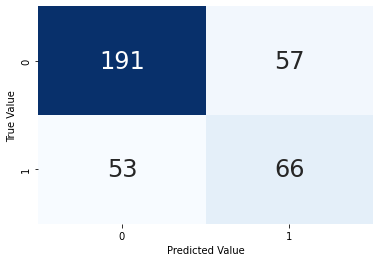

In [15]:
cf_plt =sns.heatmap(cf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
cf_plt.set(xlabel = "Predicted Value", ylabel ="True Value")
cf_plt

In [16]:
r_probs = [0 for _ in range(len(Y_v_test_data))]
xgb_prob = xgb.predict_proba(X_v_test_data)
xgb_prob = xgb_prob[:,1]
#xgb_prob

In [ ]:
#prediction_val=xgb.predict(X_v_test_data)

In [ ]:
#prediction_val=pd.DataFrame(prediction_val)

In [17]:
#prediction_val.to_csv("label_val_2048_XGB.csv")

In [18]:
r_auc_score = roc_auc_score(Y_v_test_data, xgb_prob)
r_auc_score_1 = roc_auc_score(Y_v_test_data,r_probs)
print(r_auc_score)
fpr, tpr, _ = roc_curve(Y_v_test_data, xgb_prob)
rfpr, rtpr, _ = roc_curve(Y_v_test_data, r_probs)

0.6936161561398754


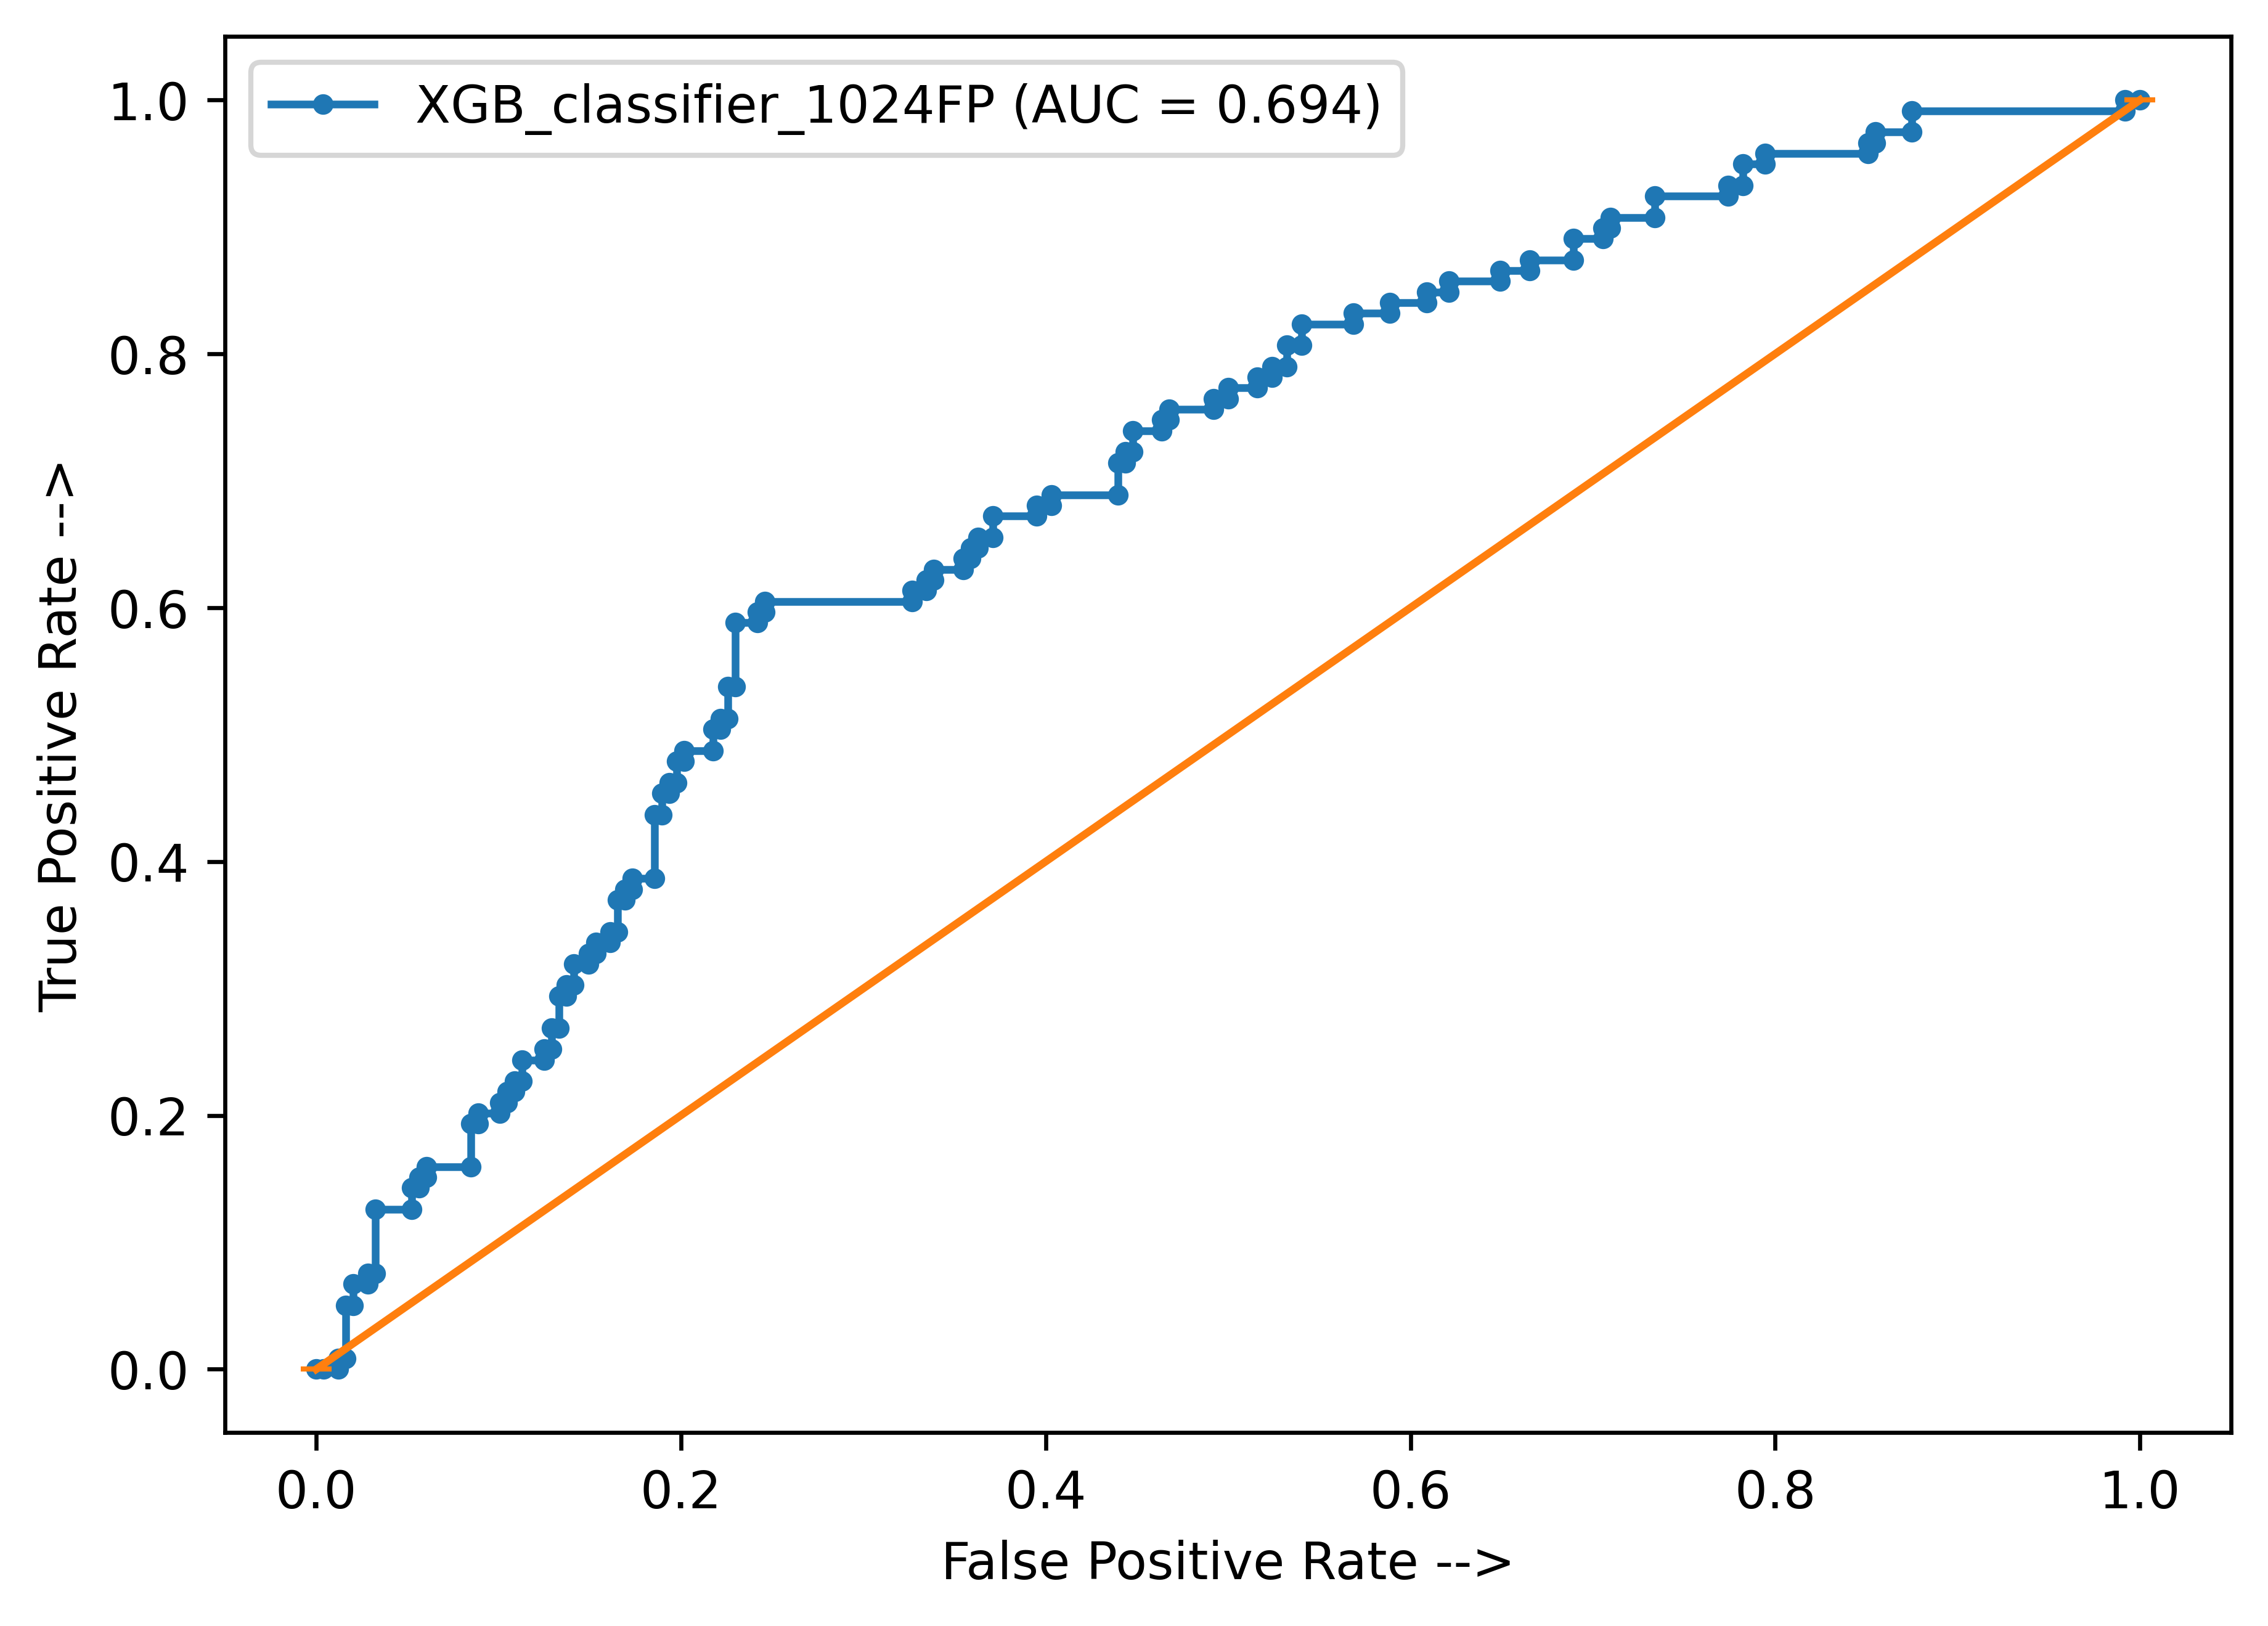

In [19]:
plt.figure(figsize=(7, 5), dpi=600)
plt.plot(fpr, tpr, marker='.', label='XGB_classifier_1024FP (AUC = %0.3f)' % r_auc_score)
plt.plot(rfpr, rtpr, marker='_' % r_auc_score_1)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()
#plt.savefig('XGB_AUC.png', dpi=600, bbox_inches='tight')

In [20]:
#Read external set
#external_data = pd.read_csv("cyclic_ind_16-09-2022_morgan_chiral_2048FP.csv")
#data_for_screening = pd.DataFrame(external_data)
#data_for_screening

In [21]:
#test external data
#test_prob = xgb.predict_proba(data_for_screening)
#test_prob_F = pd.DataFrame(test_prob)
#test_prob_F.to_csv('cyclic_XG2048_probability_FP.csv')

##Cross-validation AUC

In [22]:
from sklearn.metrics import RocCurveDisplay

In [23]:
from scipy import interp
from sklearn.metrics import roc_curve,auc
cv = StratifiedKFold(n_splits=10,shuffle=False)

/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/tmp/ipykernel_212846/1613784088.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:33:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/tmp/ipykernel_212846/1613784088.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/tmp/ipykernel_212846/1613784088.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/tmp/ipykernel_212846/1613784088.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:09:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/tmp/ipykernel_212846/1613784088.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/tmp/ipykernel_212846/1613784088.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/tmp/ipykernel_212846/1613784088.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:29:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/tmp/ipykernel_212846/1613784088.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:29:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/tmp/ipykernel_212846/1613784088.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/tmp/ipykernel_212846/1613784088.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<Figure size 4200x3000 with 0 Axes>

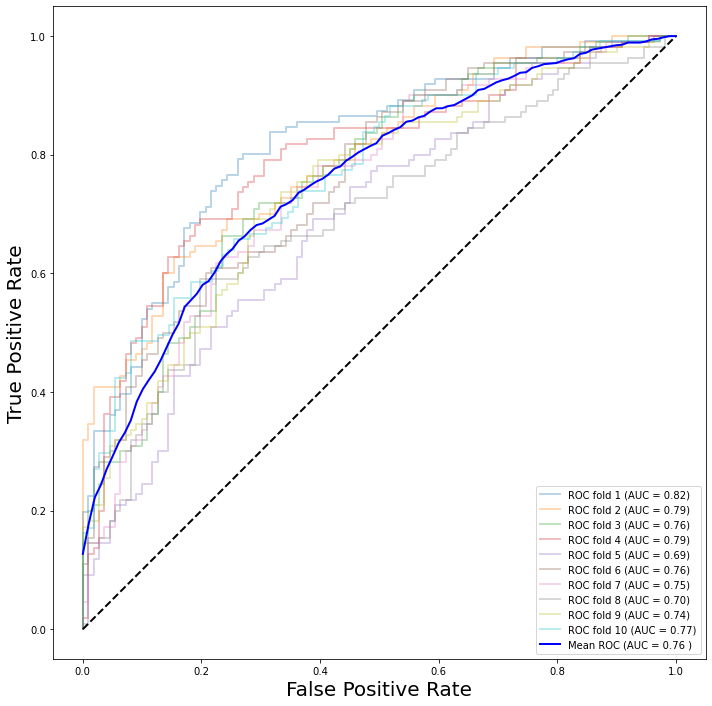

In [24]:
# plot k fold ROC
plt.figure(figsize=(7, 5), dpi=600)
x_train = x_train.T
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x_train,y_train):
    prediction = xgb.fit(x_train.iloc[train],y_train.iloc[train]).predict_proba(x_train.iloc[test])
    fpr, tpr, t = roc_curve(y_train.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.legend(loc="lower right")
plt.show()
#plt.savefig('CrossVal-AUC_CB_1024.png', dpi=600, bbox_inches='tight')

In [ ]:
##Y-randomization

In [ ]:
accuracy_list = []
mcc_list = []

for i in range(50):
    y_train = y_train.sample(frac=1, replace=False, random_state=i)
    xgb.fit(x_train, y_train)
    scrmb_predictions = xgb.predict(X_v_test_data)
    print(i)
    accuracy = roc_auc_score(Y_v_test_data, scrmb_predictions)
    accuracy_list.append(accuracy)
    mcc_v = matthews_corrcoef(Y_v_test_data, scrmb_predictions)
    mcc_list.append(mcc_v)
print(accuracy_list)
print(mcc_list)

/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0


/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1


/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2


/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
3


/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
4


/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5


/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6


/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
7


/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
8


/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
9


/home/server3/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
r_auc_score2 = roc_auc_score(Y_v_test_data, scrmb_predictions)
sns.set_style("white")
plt.figure(figsize = (20, 5), dpi=200) 
ax = sns.distplot(accuracy_list, color="green")
plt.axvline(r_auc_score, color="green")
plt.xlabel("AUC Score", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
ax.set(xlim=(0, 1))
#plt.savefig('CatBoost_scrambling_plot.png', dpi=600, bbox_inches='tight')

In [ ]:
mcc2 = matthews_corrcoef(Y_v_test_data, scrmb_predictions)
sns.set_style("white")
plt.figure(figsize = (20, 5), dpi=200) 
ax = sns.distplot(mcc_list, color="green")
plt.axvline(mcc, color="green")
plt.xlabel("MCC Score", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
ax.set(xlim=(0, 1))
#plt.savefig('CB_MCC_plot.png', dpi=600, bbox_inches='tight')

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)
#print(acc_list)
average = Average(accuracy_list)
  
# Printing average of the list
print("Average of the accuracy list =", round(average, 3))

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)
#print(mcc_list)
average = Average(mcc_list)
  
# Printing average of the list
print("Average of the mcc list =", round(average, 3))

In [ ]:
external_data = pd.read_csv("IND_07-09-2022_morgan_chiral_1024FP.csv")
data_for_screening = pd.DataFrame(external_data)

In [ ]:
test_prob = xgb.predict_proba(data_for_screening)
test_prob_F = pd.DataFrame(test_prob)
test_prob_F.to_csv('XGB1024_probability_FP.csv')